In [1]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils

plt.style.use('ggplot')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train)
test = utils.clean_data(test)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

ccc = ['age', 'age_group', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'BMI', 'MAP']
def new_cols(data):    
    for col1 in ccc:
        data[col1 + '_log'] = np.log(data[col1] + 1.1)
        for col2 in ccc:
            data['%s_mul_%s' % (col1, col2)] = data[col1] * data[col2]
            data['%s_mul_log_%s' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
            data['%s_div_log_%s' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 1)

            if col2 == col1:
                continue

            data['%s_div_%s' % (col1, col2)] = data[col1] / (data[col2] + 1)

new_cols(X_train)
new_cols(X_test)

In [3]:
loo = pd.read_csv('LOO_results.csv', sep=',', index_col='index')
loo = loo.sort_index()
strat = pd.qcut(loo, 20, labels=False).astype(str)
strat = np.hstack((strat, y_train.reshape((-1,1))))
strat =np.apply_along_axis(lambda d: str(d[0]) + '_' + str(d[1]), 1, strat)

In [4]:
use_columns = [
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
# "gluc",
"active_fair",
"smoke_restored",
"alco_restored",
# "active_restored",
"height_mul_log_gluc",
"BMI",
"age_group",
# "cholesterol_div_log_age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
# "age_group_mul_log_ap_lo",
]
mean_columns = [
#     ['cholesterol','gluc','smoke_restored','active_restored'],
# #     ['ap_hi_group'],
# #     ['ap_lo_group'],
#     ['ap_hi_group', 'age_group', 'gender'],
    
# #     ["error_group"],
# #     ['gluc'], 
#     ['MAP','active_restored'],
#     ['gender','MAP'],
# #     ['cholesterol','gluc'],
# #     ['gluc','smoke_restored'],
# #     ['gluc','active_restored'],
# #     ['gluc','alco_restored'],
# #     ['smoke_restored','active_restored'],
#     ['cholesterol','gluc','active_restored'],
#     ['gender','cholesterol','gluc']
    
    
#  ('age_group', 'gender', 'gluc', 'smoke', 'active'),
#  ('gender', 'cholesterol', 'gluc', 'alco', 'active'),
#  ('MAP', 'alco', 'active', 'ap_hi_group', 'ap_lo_group'),

]

# for i in range(10):
#         str_i = str(i)
#         use_columns.append('hi_' + str_i + 's')

from sklearn.pipeline import Pipeline, FeatureUnion
from utils import SmoothLikelihood,SmoothLikelihood2,SmoothLikelihood3,SmoothLikelihood4, ColumnsFilter
def wrap_classifier(clf):
#     kf = StratifiedKFold(random_state=111111, n_splits=10, shuffle=True)
    fs = [("filter", ColumnsFilter(use_columns))]
    for i, cc in enumerate(mean_columns):
        fs.append(('mean_'+str(i), SmoothLikelihood4(cc, 0.5,
                                                    kf=StratifiedKFold(random_state=111111+i, n_splits=20, shuffle=True),
                                                    alpha=13,
                                                    seed=10+i,
                                                    std=0.0013)))
    combined_features = FeatureUnion(fs)
    return Pipeline([ ("features", combined_features), ("model", clf)])

In [5]:
params = {
#     'colsample_bytree': 0.8,
#     'learning_rate': 0.1,
#     'n_estimators': 224,
#     'subsample': 0.8,
    
    'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(xgb.XGBClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model1-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
#                     verbose=0
             )
gc.collect()
# mean: 0.538285252534

# mean: 0.538269625709
# mean: 0.538236304885

# 0.538165802596
#  0.538044372182

# 0.538068044607
# 0.538046718451  0.538141127156
# 0.538164179021 110
# mean: 0.538159507547 105
# 0.538133633182 100

# mean: 0.538030554975
# mean: 0.538058542246
# mean: 0.538042794907

# mean: 0.538169316987
# 0.538115082189

# 0.538015868136

# mean: 0.538130995063
# mean: 0.538016211504

# mean: 0.538017046973

# mean: 0.538014096544
# 0.53799148135
# 0.538086890907

# mean: 0.538881035549
# std: 0.00142658306865

# mean: 0.538080355085
# std: 0.00125409431762

# 10 folds logloss:
# mean: 0.53759902514
# std: 0.00131889611442
# 15 Splits logloss:
# mean: 0.537692124543
# std: 0.000680289255263

#  0.537553658624


10 folds logloss:
[0.5355844195316305, 0.53655910909216464, 0.53773963469872099, 0.53850055537943453, 0.53975957230011651, 0.5383169870612543, 0.53607821997437344, 0.53762646286276594, 0.53758864184487654, 0.53720474110207739]
mean: 0.537495834385
std: 0.00116269978464
15 Splits logloss:
[0.53760805263689582, 0.5375023567382069, 0.53723482898729191, 0.53813321401959369, 0.53780022715812636, 0.53816067404051626, 0.53597913467068048, 0.53882443252010714, 0.5375065382766937, 0.5382452256586403, 0.53738898259472279, 0.537377671318927, 0.53761667643398758, 0.53804864953458309, 0.53817002370013367]
mean: 0.537706445886
std: 0.00062095045841
model1- results saved!


246

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002878A5AEBA8>]], dtype=object)

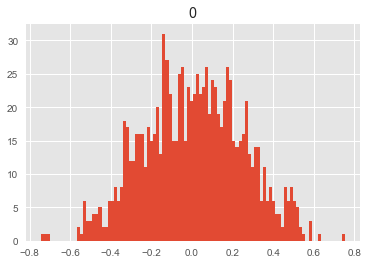

In [74]:
pd.DataFrame(np.random.normal(scale=0.25, size=(1000,1))).hist(bins=100)

In [18]:
import importlib
utils = importlib.reload(utils)

In [50]:
from utils import SmoothLikelihood4

D = X_train.copy()
G = X_test.copy()
slk = SmoothLikelihood4(['gender','MAP'], 0.5, kf=StratifiedKFold(random_state=111111, n_splits=20, shuffle=True),
                        alpha=13,
                       seed=10,
                        std=0.0013
                       )
d1 = slk.fit_transform(X_train, y_train)
g1 = slk.transform(X_test)

In [51]:
D['slk']=d1
G['slk']=g1

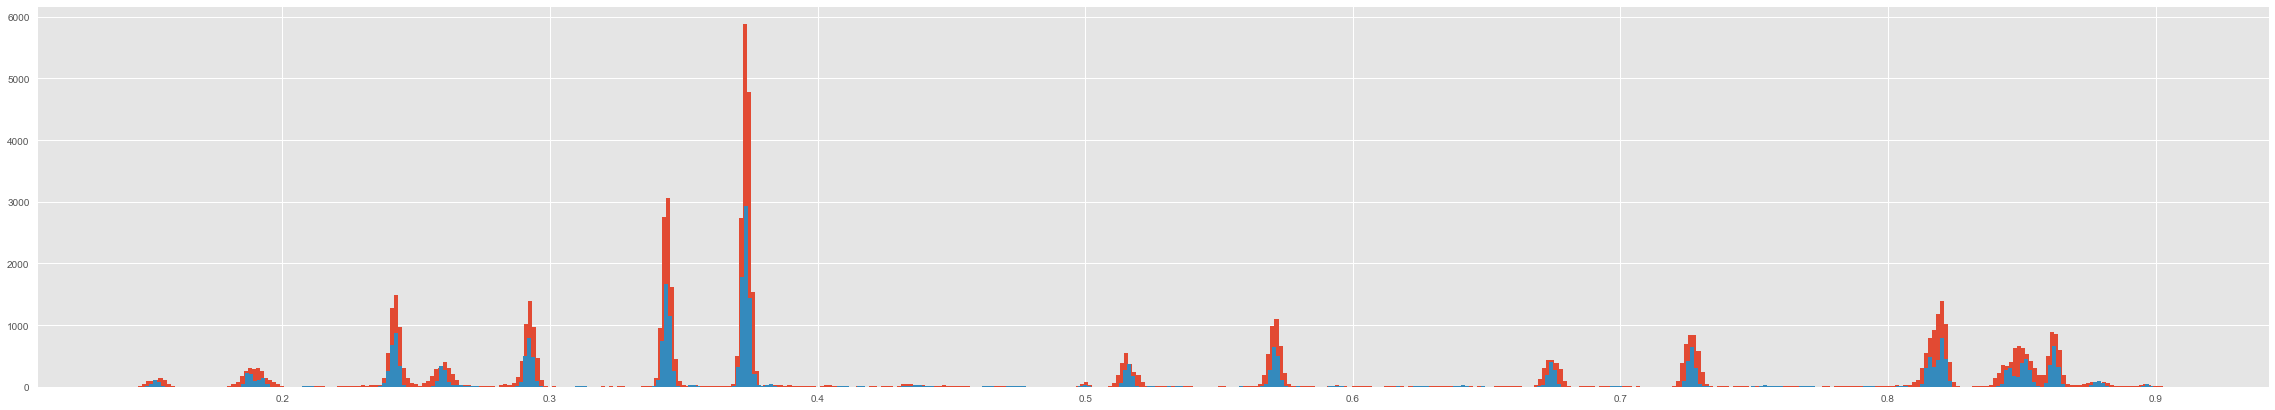

In [52]:
plt.figure(figsize=(40,7))
D['slk'].hist(bins=500)
G['slk'].hist(bins=500)

In [62]:
D.groupby(['ap_hi_group', 'age_group', 'gender'])['slk'].std().max()

0.054392829322042147

In [6]:
params = {
     'colsample_bytree': 0.95,
     'gamma': 0.55,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,

    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(xgb.XGBClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model2-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53621854076557018, 0.53671467667154171, 0.53785833236409908, 0.53887634320909306, 0.54040929569983065, 0.53854971592716183, 0.53593053353167508, 0.53796925385647876, 0.53776347541901204, 0.53742250891048571]
mean: 0.537771267635
std: 0.00125978114173
15 Splits logloss:
[0.53792029706149225, 0.53796479774568051, 0.53756138339918103, 0.53885004129557912, 0.53766862681623373, 0.53859242251391215, 0.53621256896543001, 0.53887050457378582, 0.53795376725122335, 0.53882877584262978, 0.53796384426632093, 0.53760679947114776, 0.53802274892754143, 0.53851110382457934, 0.5382489424028567]
mean: 0.538051774957
std: 0.00065647721665
model2- results saved!


138

In [7]:
import lightgbm as lgb

params = {
    'colsample_bytree': 0.95,
#      'gamma': 0.55,
     'learning_rate': 0.02,
#      'max_depth': 5,
     'num_leaves': 2**5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,
       
    'nthread': 4,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(lgb.LGBMClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model3-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53674828691443466, 0.53740081774898096, 0.53849129255010941, 0.53882538471335073, 0.540049613051651, 0.53907674070639899, 0.53585892069921393, 0.53816434662742074, 0.5381721388074262, 0.53751046821648107]
mean: 0.538029801004
std: 0.00114369314275
15 Splits logloss:
[0.53852821395001127, 0.53801697427516582, 0.53769298530942511, 0.53963810166474668, 0.53835073587024918, 0.53892591081315289, 0.53651119448287088, 0.5394750358892143, 0.53825725475911812, 0.53923570720354808, 0.53791071578963778, 0.53774567121550843, 0.53835163260492069, 0.53884289700829302, 0.5387461103420671]
mean: 0.538415276079
std: 0.000770252239898
model3- results saved!


133

In [20]:
clf = xgb.XGBClassifier(
        learning_rate=0.06,
        n_estimators=114,
        max_depth=5,
        min_child_weight=5,
        gamma=0.3,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=9,
        reg_lambda=1.4,
        nthread=4,
       
        seed=1111
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model4-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53684701946806423, 0.53904627581058673, 0.53925450638625105, 0.53989188552933032, 0.53915486433130788, 0.53996754890181486, 0.53685438735289981, 0.53911923948677121, 0.53806970960961065, 0.53829662128392108]
mean: 0.538650205816
std: 0.00105888278682
15 Splits logloss:
[0.53786308206546873, 0.53757894959336239, 0.53832602344400116, 0.5390815991984591, 0.5389430207432736, 0.53880189967403813, 0.53661770072153636, 0.53992167316040118, 0.5384940600400524, 0.53887855581886002, 0.53838546988332558, 0.53826701575570868, 0.53844438684678508, 0.53856093274589101, 0.53924811522094973]
mean: 0.538494165661
std: 0.000741658040147
model4- results saved!


360

In [8]:
clf = xgb.XGBClassifier(
        learning_rate=0.07,
        n_estimators=218,
        max_depth=3,
        min_child_weight=5,
        gamma=0.2,
        subsample=0.6,
        colsample_bytree=0.55,
        reg_alpha=0,
        reg_lambda=1.0,
        nthread=4,
        tree_method='hist',
        grow_policy='lossguide',
       
        seed=2222
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model5-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53670905013243275, 0.53663060220198355, 0.5391350654835515, 0.539837075515748, 0.54015106013403613, 0.53894697401505498, 0.53691679622782151, 0.5387215399340789, 0.53726651191340424, 0.53865786091446444]
mean: 0.538297253647
std: 0.00124539071034
15 Splits logloss:
[0.53836993021491386, 0.53776298340294693, 0.5381327864122355, 0.53941939751174128, 0.53829588755548352, 0.53894926255409203, 0.53698739238899373, 0.53926021760595699, 0.53878827601431734, 0.53903658839834057, 0.53822160419404863, 0.53772581928924079, 0.53871668544065743, 0.5392587703452224, 0.53928808362533653]
mean: 0.538547578997
std: 0.000678594386135
model5- results saved!


354

In [22]:
clf = lgb.LGBMClassifier(
        learning_rate=0.07,
        n_estimators=218,
#         max_depth=3,
        num_leaves=2**3,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=0.55,
        reg_alpha=0,
        reg_lambda=1.0,
        nthread=4,
       
        seed=2222
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model6-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53729233228329154, 0.53824221983905107, 0.53925314271520197, 0.53967301022840231, 0.54101326975537467, 0.53878151429919197, 0.53722921025452586, 0.53908484341327723, 0.53750030455639575, 0.53849853217026511]
mean: 0.538656837951
std: 0.00112134847992
15 Splits logloss:
[0.53893002614750352, 0.53796856877313037, 0.53833071830764645, 0.53958581595393551, 0.53885994773688695, 0.53955169944489623, 0.53714436424151102, 0.53964319776051539, 0.53911891171222026, 0.53859584862403642, 0.53831491700316625, 0.53829827023891386, 0.53879225862120805, 0.53943793592587541, 0.53973409054781374]
mean: 0.538820438069
std: 0.000705708960613
model6- results saved!


349

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler  

# scaler = StandardScaler()  
# X = pd.concat((X_train, X_test), axis=0)
# scaler.fit(X)
# gc.collect()

# clf = MLPClassifier(solver='adam', activation='relu', learning_rate = 'adaptive', tol = 1e-5,
#                     hidden_layer_sizes=(8, 3), random_state=1100)

# utils.execute_model(clf,
#               scaler.transform(X_train),
#               y_train,
#               scaler.transform(X_test) ,
#               model_name="model4",
#               mean_columns = mean_columns,
#               use_columns = use_columns,
#               n_splits=15,
#               n_folds=10,
#               alpha=20
#              )
# gc.collect()

In [ ]:
models = ['model1','model2','model3']
result1 = utils.merge_models(models, method='mean')
pd.DataFrame(result1).to_csv('models1234_mean.csv', index=False, header=False, sep=';')

In [11]:
models = ['KERAS_1', 'model1-','model2-','model3-','model5-','model1','model3','model1+','model2+']
result1 = utils.merge_models(models, method='mean')
pd.DataFrame(result1).to_csv('models1234-_mean.csv', index=False, header=False, sep=';')
# 0.537888791163	0.53818930228	0.537494736443	0.537712095482


KERAS_1
0.541188333484	0.541405679164	0.541188333484	0.541405679164

model1-
0.537495498978	0.537706445895	0.53815759386	0.538294889252

model2-
0.537771013645	0.538051774932	0.537698317632	0.53784253395

model3-
0.538029709996	0.538415276079	0.53753730697	0.53771354451

model5-
0.538296979367	0.538547578947	0.537508023582	0.537696880375

model1
0.538080079502	0.538009376104	0.537479453883	0.537609018688

model3
0.538702687693	0.539402696417	0.53741390216	0.770362462535

model1+
0.537856175071	0.538141755107	0.537347025354	0.544398539016

model2+
0.538247526491	0.53857718903	0.537341094639	0.543130882008


In [ ]:
# 0.537557163108	0.537699150119 = 0.5428822 # + keras
# 0.537519393165	0.537619764695 = 0.5432057 * new log features

# 0.538126862768	0.538047373071 = 0.5431843
# 0.538084892954	0.538027778903 = 0.5433475
# 0.538157706723	0.538186899005 = 0.5430039 # без стасо-колонок
# 0.537450021945	0.537849282831 = 0.5434434
# 0.537513993512	0.537749328355 = 0.5433418

# 0.537790804547	0.538014148853 = 0.5438901 # overfit full

# 0.537368545033                   = 0.5428417
# 0.537561506209                   = 0.5432193
# 0.537449005194                   = 0.5428384


# 0.537727687638	0.537773366433 = 0.5437636
# 0.537662820586	0.538506869394 = 0.5433681
# 0.537639730851	0.538322959718 = 0.5436416 # overfit due to smoke leak
# 0.537723242359	0.538418956272 = 0.5433819
# 0.537697918691	0.538454608940 = 0.5435035
# 0.537797383673	0.538468964022 = 0.5433098
# 0.537998452494	0.538697384187 = 0.5433633
# 0.538141859286	0.538727942758 = 0.5434983


#--------------
0.5430039

In [ ]:
%%time
params = {
    'learning_rate': 0.1,
    'n_estimators': 50,
    
    'n_jobs': 8,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(),
              X_train,
              y_train,
              mean_columns = mean_columns,
              use_columns = use_columns,
              n_folds=10,
              alpha=13,
             )
gc.collect()

In [ ]:
# 0.537735274001	0.537762262313 = 0.5439345
# 0.538040557134	0.538014744278 = 0.5436639
# 0.5374	0.5374                 = 0.5440495
# 0.537603843701	0.537606129043 = 0.5448082

# Со столбцами Стаса альфа=20
# 0.537387582699	0.537559051543 = 0.5482682

# 0.537684932504	0.537640948053 = 0.5514443 добавил один столбик "по Стасу"
# 0.537748490027	0.537673097079 = 0.5517563 20 фолдов для подсчета среднего

# Без них
# 0.538947547578	0.538808662263 = 0.5441786
# 0.538231869380	0.538120316604 = 0.5435621